In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('emails.csv')

In [7]:
df.head(5)

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [8]:
df['Email No.'].is_unique

True

In [9]:
df = df.drop(columns=['Email No.'])

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler#, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [11]:
X= df.drop(columns='Prediction')
y= df['Prediction']

7 Classification models will be compared. RandomForest and ADABoost are tested with more estimators to further evaluation of data. SVM is compared using Linear kernel vs. Sigmoid kernel.

In [12]:
classifiers = {
    'LGBM': LGBMClassifier(verbose=0),
    'CatBoost':CatBoostClassifier(silent=True),
    'LogisticRegression': LogisticRegression(max_iter=500),
    'RandomForest100': RandomForestClassifier(),
    'RandomForest200': RandomForestClassifier(n_estimators=200),
    'SVMLinear': SVC(kernel='linear', probability=True),
    'SVMSigmoid': SVC(kernel='sigmoid', probability=True),
    'GradientBoost': GradientBoostingClassifier(),
    'ADABoost100': AdaBoostClassifier(n_estimators=100),
    'ADABoost200': AdaBoostClassifier(n_estimators=200),
}

In [24]:
def sc_pca_class_test(X, y, scaler, reduce, components, ts, classifier, split_method, rs, apply_smote=False):

    r_params = {'n_components': components, 'random_state': rs}
    
    r_dc = {'pca': PCA(**r_params),
             'svd' : TruncatedSVD(**r_params),
             'tsne': TSNE(method='exact', n_components= components, random_state= rs),
             'lda_svd' : LDA(n_components= 2, solver= 'svd')}
    
    if reduce in r_dc.keys():
        if reduce[:3].lower() == 'lda':
            X = r_dc[reduce].fit_transform(X, y)
        else:
            X = r_dc[reduce].fit_transform(X)   
        
    n_splits=int((1/ts))
    
    split_dc = {
           'skf' : StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs),
            'sss' : StratifiedShuffleSplit(n_splits=n_splits, test_size=ts, random_state=rs),    
            'kf': KFold(n_splits=n_splits, shuffle=True, random_state=rs)
    }
    
    if split_method == 'tt':

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)
        
    elif split_method in split_dc.keys():
        
        for train_index, test_index in split_dc[split_method].split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    else:
        print(split_method + ' not allowed')
        return None
    
    if apply_smote:
        smote = SMOTE(random_state=rs)
        X_train, y_train = smote.fit_resample(X_train, y_train)   
    
    if scaler:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
    classifier.fit(X_train, y_train)    
    
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1] if hasattr(classifier, 'predict_proba') else None

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    }

    if y_pred_proba is not None:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        ap_score = average_precision_score(y_test, y_pred_proba)
        metrics.update({
            'precision_recall': (precision, recall, thresholds),
            'average_precision': ap_score
        })
        
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)   
        metrics.update({'roc_curve': (fpr, tpr, roc_thresholds),
        'roc_auc': roc_auc
        })
        
    return metrics

# First Tests:    
>Smote vs. Non Smote Sampling  
  10 Models  
  3 split methods: Train Test Split, Stratified KFold, StratifiedShuffleSplit   
  3 scaling methods: StandardScaler(), MinMaxScaler(), and MaxAbsScaler()
 
 Returning the metrics required to plot roc_auc & precision-recall curves as well as the precision, recall, accuracy, average precision.

In [28]:
metrics1 = {}

for c_name, classifier in classifiers.items():
    for split_method in ['tt','skf', 'sss']:
        for sc in [MinMaxScaler(), StandardScaler(), MaxAbsScaler()]:
            scores = sc_pca_class_test(X, y, sc, None, 50, 0.2, classifier, split_method, 99)
            key = c_name + '_' + split_method + '_' + sc.__class__.__name__

            if key not in metrics1:
                metrics1[key] = {}

            metrics1[key].update(scores)

In [30]:
results_df = pd.DataFrame.from_dict(metrics1, orient='index').sort_values(by=['f1', 'roc_auc'], ascending=False).reset_index()
results_df[['model', 'split_method', 'scaler']] = results_df['index'].str.split('_', expand=True) 
results_df = results_df.set_index('index')

#### SMOTE Tests on same combinations models, split_methods, and scalers for comparison

In [33]:
from imblearn.over_sampling import SMOTE

metrics_smote = {}
 
for c_name, classifier in classifiers.items():
    for split_method in ['tt','skf', 'sss']:
        for sc in [MinMaxScaler(), StandardScaler(), MaxAbsScaler()]:
            scores = sc_pca_class_test(X, y, sc, None, 50, 0.2, classifier, split_method, 99, apply_smote=True)
            key = c_name + '_' + split_method + '_' + sc.__class__.__name__

            if key not in metrics_smote:
                metrics_smote[key] = {}

            metrics_smote[key].update(scores)

In [35]:
smote_df = pd.DataFrame.from_dict(metrics_smote, orient='index').sort_values(by=['f1', 'roc_auc'], ascending=False).reset_index()
smote_df[['model', 'split_method', 'scaler']] = smote_df['index'].str.split('_', expand=True)   
smote_df = smote_df.set_index('index')

In [36]:
round(results_df[results_df.model=='SVMSigmoid']['accuracy'].mean(),2)

0.85

 
    SVM with Sigmoid kernel is by far the worst performer. SVM with Sigmoid provides only 85% accuracy on average. Compared to simply predicting all emails as spam, that is only a 15% increase. This model does not work for this problem.

In [41]:
new_reg = results_df[results_df.model != 'SVMSigmoid']
new_smote = smote_df[smote_df.model != 'SVMSigmoid']

In [42]:
def get_aggregate_df(df, agg_dc, group_col):
    return df.groupby(group_col).agg(agg_dc).reset_index().set_index(group_col)

In [43]:
metric_cols = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision']
metric_mean_dc = {k:'mean' for k in metric_cols}

In [44]:
split_smote_mean = get_aggregate_df(new_smote, metric_mean_dc, 'split_method')
model_smote_mean = get_aggregate_df(new_smote, metric_mean_dc, 'model')
scalar_smote_mean = get_aggregate_df(new_smote, metric_mean_dc, 'scaler')

In [45]:
split_reg_mean = get_aggregate_df(new_reg, metric_mean_dc, 'split_method')
model_reg_mean = get_aggregate_df(new_reg, metric_mean_dc, 'model')
scalar_reg_mean = get_aggregate_df(new_reg, metric_mean_dc, 'scaler')

Measuring the Effect of Performance according to the split_method, scaler, and model level.

In [46]:
split_diffs = split_smote_mean.T - split_reg_mean.T
scalar_diffs = scalar_smote_mean.T - scalar_reg_mean.T
model_diffs = model_smote_mean.T - model_reg_mean.T

In [47]:
split_avg = (split_smote_mean.T + split_reg_mean.T) / 2
scalar_avg = (scalar_smote_mean.T + scalar_reg_mean.T) / 2
model_avg = (model_smote_mean.T + model_reg_mean.T) / 2

Below, overall aggregates split between 'smote' balanced sampling and 'non_smote', sampling- retaining the 70/30 class imbalance.

In [61]:
reg_agg = pd.DataFrame(new_reg[metric_cols].mean()).rename(columns={0:'regular sampling'})
smote_agg = pd.DataFrame(new_smote[metric_cols].mean()).rename(columns={0:'balanced sampling (SMOTE)'})

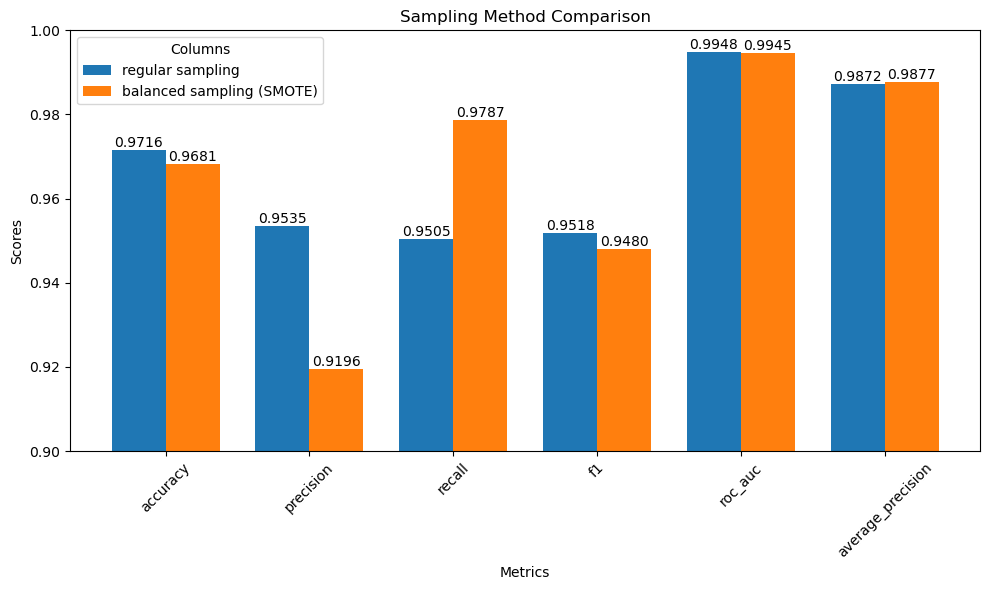

In [62]:
plot_bar_graphs(pd.concat([reg_agg.T, smote_agg.T]).T,
    columns=['regular sampling', 'balanced sampling (SMOTE)'],
    title='Sampling Method Comparison',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.90,  # Adjust these values if needed
    bar_max=1,
    figsize=(10, 6),
    legend=True,
    grid=False,
    decimal=4
)


### Smote Effect: Oversampling the minority & positive class, spam email classification:
1. Precision Decrease: **Increased** # of normal emails incorrectly marked as spam
2. Recall Increase: **Decreased** # of spam emails that sneak into the inbox  
  
  Smote trains with an even split: 50% Spam & 50% non-spam, but the test set has 30% spam emails. The model is better at identifying spam emails, because it trains on more of them, but trains on less (relatively), regular emails. SMOTE sampling ends up catching more regular emails as spam because it has trained on less of them.


## Split Method

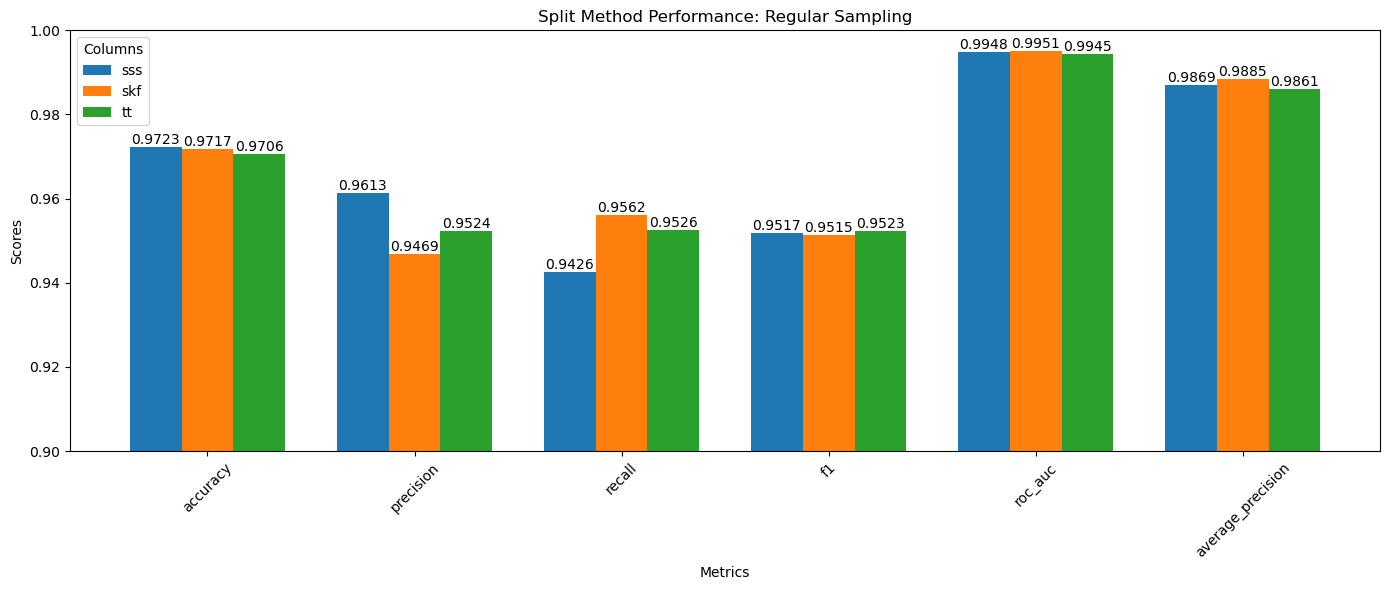

In [63]:
plot_bar_graphs(split_reg_mean.T,
    columns=['sss','skf','tt'],
    title='Split Method Performance: Regular Sampling',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9,  # Adjust these values if needed
    bar_max=1,
    figsize=(14, 6),
    legend=True,
    grid=False,
    decimal=4
)


Regular Sampling  
>*StratifiedShuffleSplit*: Highest Precision, accuracy  
*StratifiedKFold:* Highest Recall, roc_auc, average_precision  
*Train Test Split:* Highest f1 (combined precision & recall)

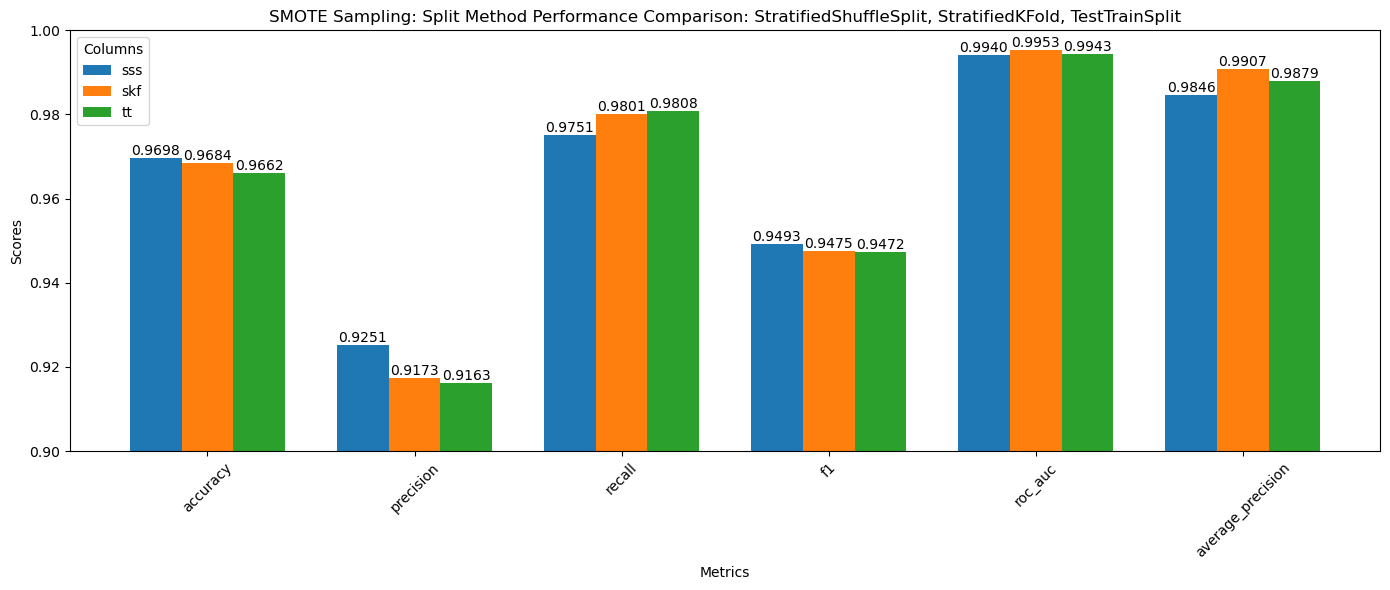

In [64]:

plot_bar_graphs(split_smote_mean.T,
    columns=['sss','skf','tt'],
    title='SMOTE Sampling: Split Method Performance Comparison: StratifiedShuffleSplit, StratifiedKFold, TestTrainSplit',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9,  # Adjust these values if needed
    bar_max=1,
    figsize=(14, 6),
    legend=True,
    grid=False,
    decimal=4
)


Balanced Sampling with SMOTE
>*StratifiedShuffleSplit*: Highest accuracy, Precision, f1. Lowest average precision & roc_auc  
*StratifiedKFold:* Highest roc_auc, average precision  
*Train Test Split:* Highest Recall 

In [65]:
pr_diffs_sp = pd.DataFrame(split_diffs.T['recall'] + split_diffs.T['precision']).rename(columns={0:'net_change_in_precision_recall'})
pr_diffs_sp = pd.concat([pr_diffs_sp,split_diffs.T[['f1']]],axis=1).rename(columns={'f1':'net_change_in_f1'})

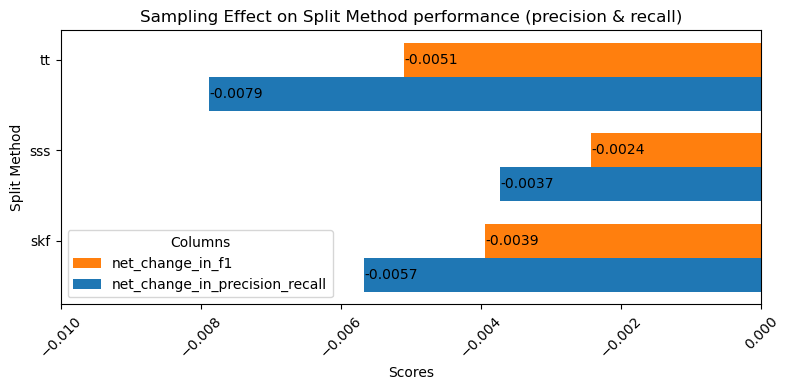

In [70]:
plot_bar_graphs(pr_diffs_sp,
    columns=pr_diffs_sp.columns,
    title='Sampling Effect on Split Method performance (precision & recall)',
    x_label='Split Method',
    y_label='Scores',
    horizontal=True,  # Set to True if you prefer horizontal bars
    bar_min=-0.01, # Adjust these values if needed
    bar_max=0,
    figsize=(8,4),
    legend=True,
    grid=False,
    decimal=4
)


SMOTE shows best results with *StratifiedShuffleSplit*. Mildly worse f1 with test_train_split, while showing a stronger gain in precision relative to recall

## Scaling Method

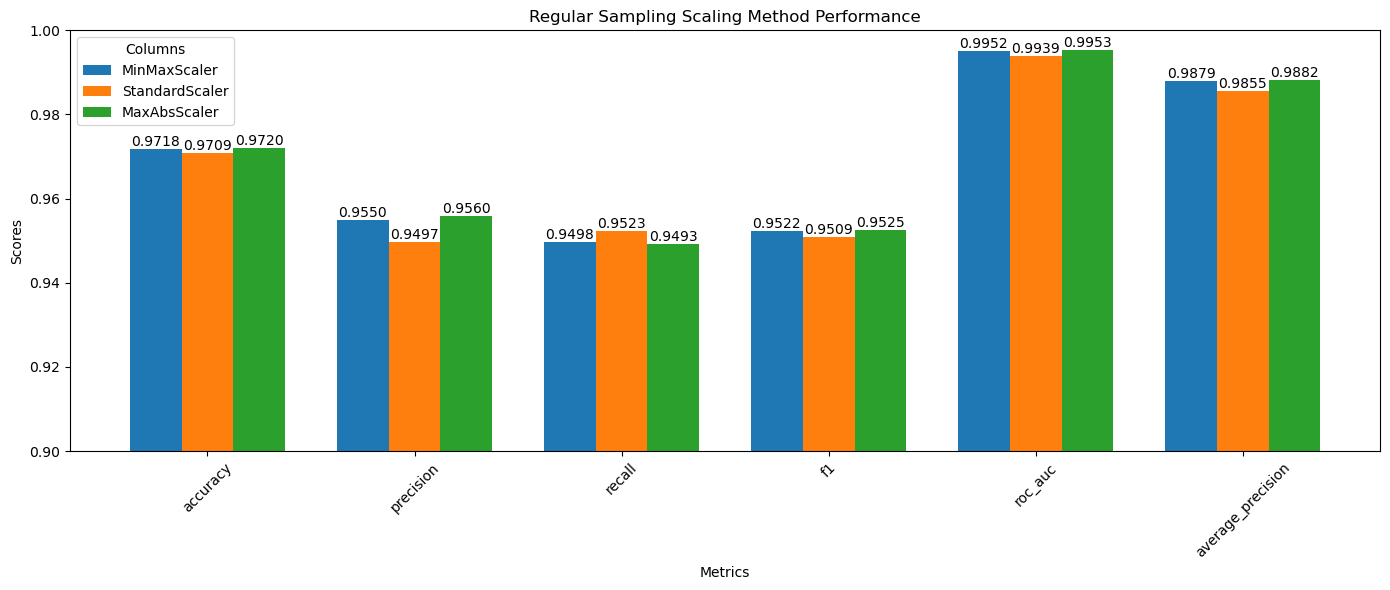

In [72]:
plot_bar_graphs(scalar_reg_mean.T,
    columns=results_df.scaler.unique().tolist(),
    title='Regular Sampling Scaling Method Performance',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9,  
    bar_max=1,
    figsize=(14,6),
    legend=True,
    grid=False,
    decimal=4
)


Regular Sampling
>*MinMaxScaler:* Slightly worse than MaxAbsScaler, with slightly better recall  
*StandardScaler:* best recall, worst everything else   
*MaxAbsScaler:* Highest Accuracy, Precision, f1, roc_auc, average_precision

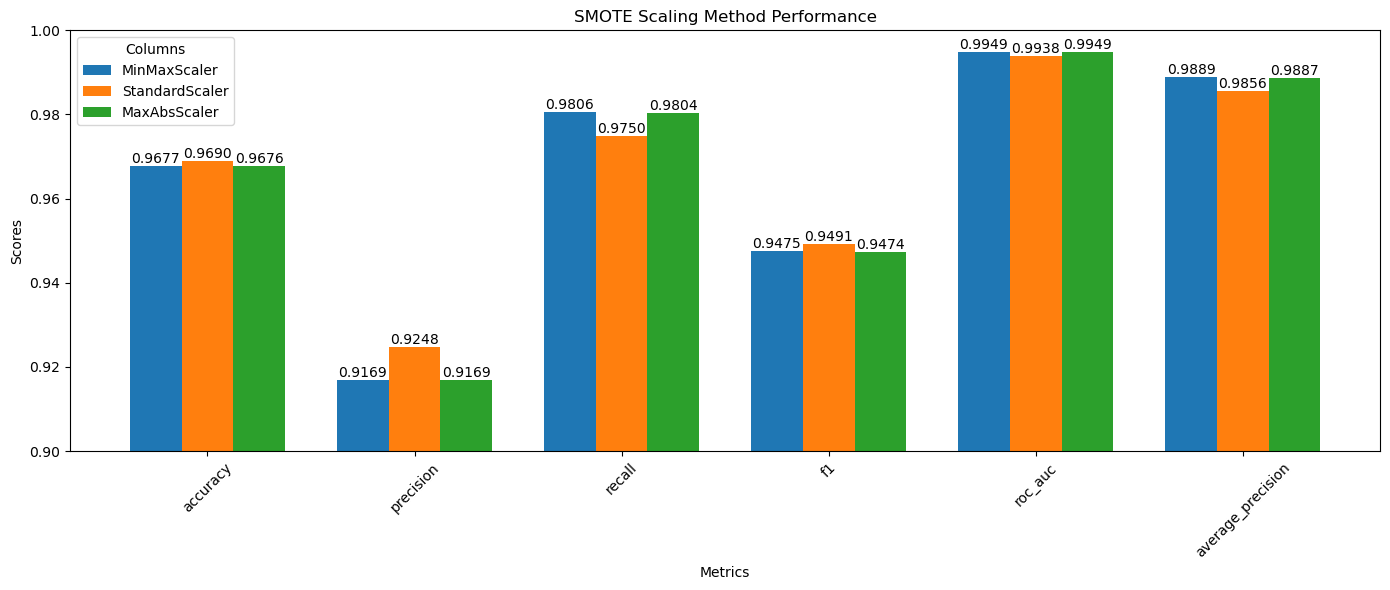

In [73]:
plot_bar_graphs(scalar_smote_mean.T,
    columns=results_df.scaler.unique().tolist(),
    title='SMOTE Scaling Method Performance',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9,  
    bar_max=1,
    figsize=(14,6),
    legend=True,
    grid=False,
    decimal=4
)               

Balanced Sampling (SMOTE)
>*MinMaxScaler:* highest recall, average_precision.  
*StandardScaler:* best accuracy, precision, f1  
*MaxAbsScaler:* Equal ROC_AUC but slightly worse than MinMax

In [74]:
pr_diffs_sc = pd.DataFrame(scalar_diffs.T['recall'] + scalar_diffs.T['precision']).rename(columns={0:'net_change_in_precision_recall'})
pr_diffs_sc = pd.concat([pr_diffs_sc,scalar_diffs.T[['f1']]],axis=1).rename(columns={'f1':'net_change_in_f1'})

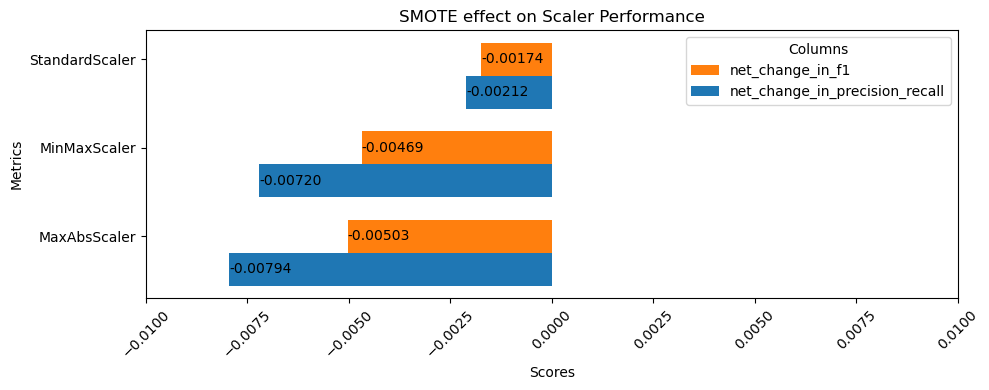

In [77]:
plot_bar_graphs(pr_diffs_sc,
    columns=pr_diffs_sc.columns,
    title='SMOTE effect on Scaler Performance',
    x_label='Metrics',
    y_label='Scores',
    horizontal=True,  # Set to True if you prefer horizontal bars
    bar_min=-.01,  # Adjust these values if needed
    bar_max=0.01,
    figsize=(10,4),
    legend=True,
    grid=False,
    decimal=5
)


*SMOTE works best with StandardScaler*, for this word count dataset, but still overall worse. 

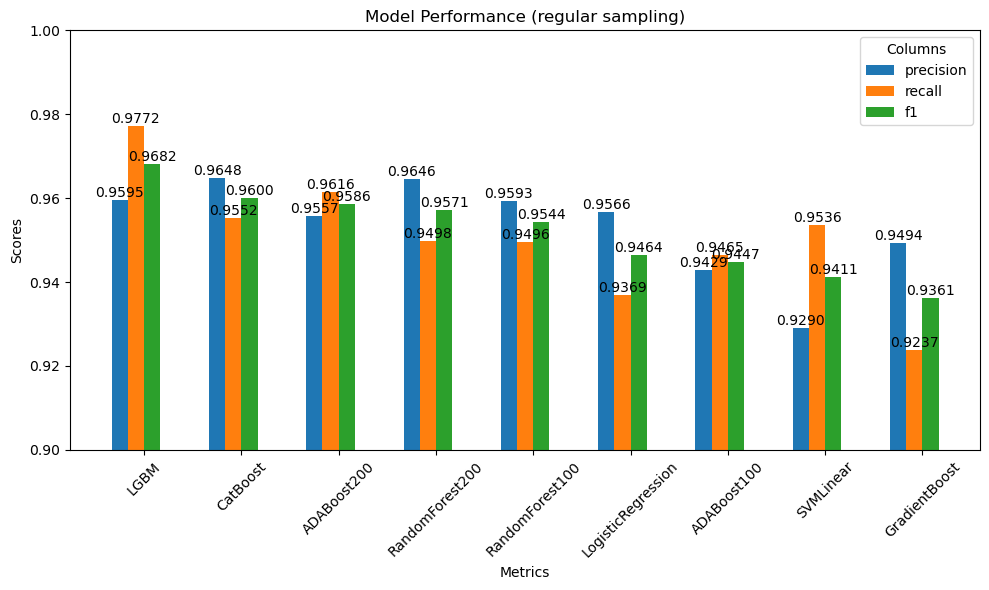

In [78]:
plot_bar_graphs(model_reg_mean[['f1','recall','precision']].sort_values(by='f1',ascending=False),
    columns=model_reg_mean.columns,
    title='Model Performance (regular sampling)',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9, 
    bar_max=1,
    figsize=(10,6),
    legend=True,
    grid=False,
    decimal=4,
    bar_width=1
)               

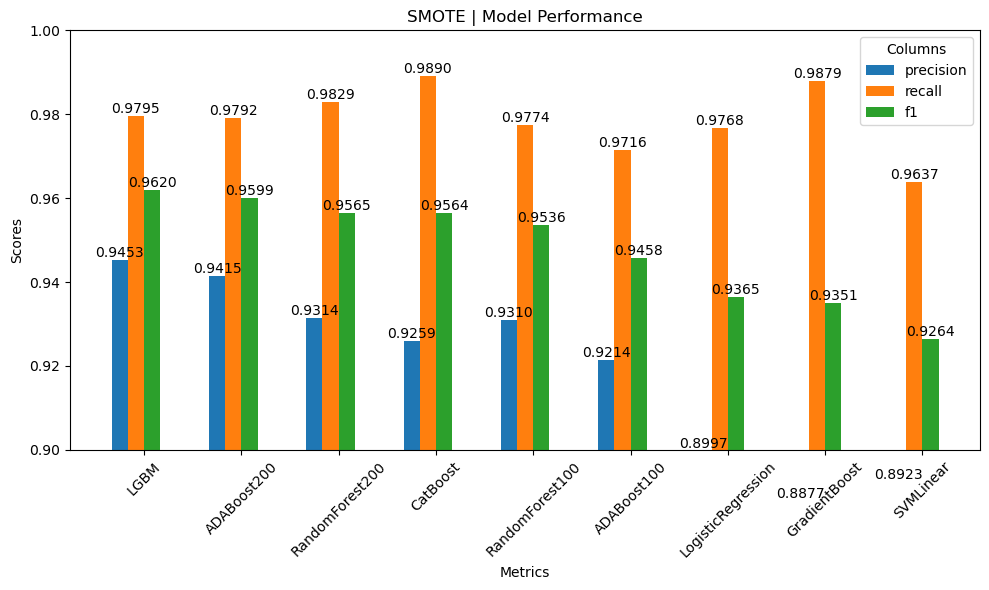

In [79]:
plot_bar_graphs(model_smote_mean[['f1','recall','precision']].sort_values(by='f1',ascending=False),
    columns=model_smote_mean.columns,
    title='SMOTE | Model Performance',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9, 
    bar_max=1,
    figsize=(10,6),
    legend=True,
    grid=False,
    decimal=4,
    bar_width=1
)               

In [80]:
pr_diffs_mod = pd.DataFrame(model_diffs.T['recall'] + model_diffs.T['precision']).rename(columns={0:'net_change_in_precision_recall'})
pr_diffs_mod = pd.concat([pr_diffs_mod,model_diffs.T[['f1']]],axis=1).rename(columns={'f1':'net_change_in_f1'})

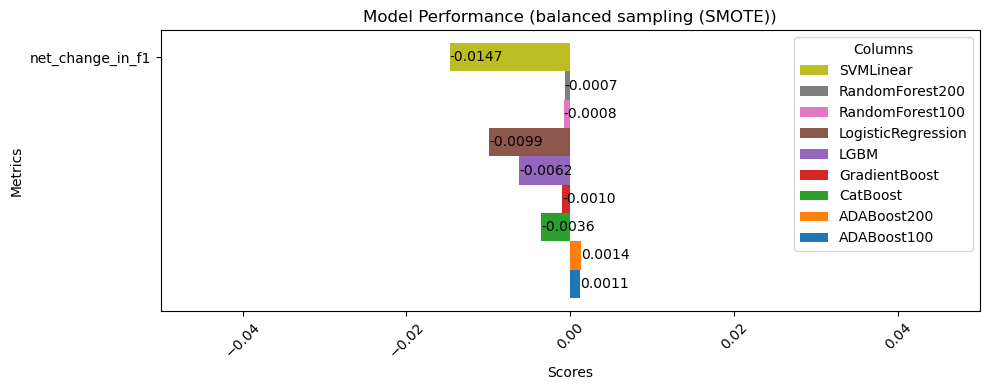

In [81]:
plot_bar_graphs(pr_diffs_mod[['net_change_in_f1']].sort_values(by='net_change_in_f1', ascending=False).T,
    columns=pr_diffs_mod.T.columns,
    title='Model Performance (balanced sampling (SMOTE))',
    x_label='Metrics',
    y_label='Scores',
    horizontal=True,  # Set to True if you prefer horizontal bars
    bar_min=-0.05, 
    bar_max=0.05,
    figsize=(10,4),
    legend=True,
    grid=False,
    decimal=4
)               

Of the top performing models, Balanced sampling has a positive effect on *ADABoost*, but negative effect on all other models, especially SVMLinear and LogisticRegression.

In [82]:
results_df['smote'] = 'regular'
smote_df['smote'] = 'smote'

results_df['index'] = results_df.index
smote_df['index'] = smote_df.index

In [83]:
results_df['index'] = results_df['index'] + '_' + results_df['smote']
results_df = results_df.set_index('index')

smote_df['index'] = smote_df['index'] + '_' + smote_df['smote']
smote_df = smote_df.set_index('index')

In [86]:
combined_df = pd.concat([results_df, smote_df])
combined_df.index.name = None

### High Precision: Fewer False Positives, Fewer Regular Emails caught as spam  
Usually at the cost of more real emails caught as spam 

  ### High Recall: Fewer False Negatives, Fewer Spam allowed in Inbox
 Usually at the cost of more spam in the inbox.



### High Precision Models
>"Relaxed Spam Filter" Highest number of real emails allowed into inbox (and least real number filtered as spam), but also some spam emails allowed into inbox.

In [95]:
combined_df.sort_values(by=['precision','average_precision'],ascending=False).head(10)[['model','precision','f1','recall','roc_auc', 'average_precision']]

,model,precision,f1,recall,roc_auc,average_precision
LogisticRegression_sss_MinMaxScaler_regular,LogisticRegression,0.978799,0.950257,0.923333,0.995646,0.986889
LogisticRegression_sss_MaxAbsScaler_regular,LogisticRegression,0.978799,0.950257,0.923333,0.995646,0.986889
CatBoost_sss_MinMaxScaler_regular,CatBoost,0.976027,0.962838,0.950000,0.996966,0.991602
CatBoost_sss_StandardScaler_regular,CatBoost,0.976027,0.962838,0.950000,0.996966,0.991602
CatBoost_sss_MaxAbsScaler_regular,CatBoost,0.976027,0.962838,0.950000,0.996966,0.991602
CatBoost_tt_MinMaxScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
CatBoost_tt_StandardScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
CatBoost_tt_MaxAbsScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
RandomForest200_tt_StandardScaler_regular,RandomForest200,0.974441,0.965190,0.956113,0.996931,0.993875
RandomForest100_tt_MaxAbsScaler_regular,RandomForest100,0.971154,0.960380,0.949843,0.996605,0.992673


While Logistic Regression shows highest precision, the recall is a full 3% lower! when taking f1 into account, these three models showed the most promise.

In [96]:
models_for_selection = ['LogisticRegression_sss_MinMaxScaler_regular', 'CatBoost_sss_MinMaxScaler_regular', 'CatBoost_tt_StandardScaler_regular']

### High Recall Models
>"Aggressive Spam Filter" Highest number of correct spam email classification, but also some real emails are classified as spam. 

In [89]:
combined_df.sort_values(by=['recall', 'average_precision'],ascending=False).head(10)[['model','precision','f1','recall','roc_auc','average_precision']]

,model,precision,f1,recall,roc_auc,average_precision
CatBoost_tt_MinMaxScaler_smote,CatBoost,0.918841,0.954819,0.99373,0.997723,0.994990
CatBoost_tt_StandardScaler_smote,CatBoost,0.918841,0.954819,0.99373,0.997723,0.994990
CatBoost_tt_MaxAbsScaler_smote,CatBoost,0.918841,0.954819,0.99373,0.997723,0.994990
GradientBoost_tt_StandardScaler_smote,GradientBoost,0.885475,0.936484,0.99373,0.994656,0.988042
GradientBoost_tt_MaxAbsScaler_smote,GradientBoost,0.885475,0.936484,0.99373,0.994656,0.988039
GradientBoost_tt_MinMaxScaler_smote,GradientBoost,0.885475,0.936484,0.99373,0.994621,0.987926
CatBoost_skf_MinMaxScaler_smote,CatBoost,0.925234,0.956522,0.99000,0.998447,0.996324
CatBoost_skf_StandardScaler_smote,CatBoost,0.925234,0.956522,0.99000,0.998447,0.996324
CatBoost_skf_MaxAbsScaler_smote,CatBoost,0.925234,0.956522,0.99000,0.998447,0.996324
LGBM_skf_MinMaxScaler_smote,LGBM,0.942857,0.965854,0.99000,0.998470,0.996219


CatBoost with test_train_split and smote has highest recall performance. 

In [97]:
models_for_selection += ['CatBoost_tt_MinMaxScaler_smote', 'CatBoost_skf_StandardScaler_smote']

### f1
> Balances precision and recall according to class imbalances in dataset

In [91]:
combined_df.sort_values(by=['f1','roc_auc'],ascending=False).head(10)[['model','precision','f1','recall','roc_auc']]

,model,precision,f1,recall,roc_auc
LGBM_sss_MinMaxScaler_regular,LGBM,0.966887,0.970100,0.973333,0.997351
LGBM_sss_StandardScaler_regular,LGBM,0.966887,0.970100,0.973333,0.997351
LGBM_sss_MaxAbsScaler_regular,LGBM,0.966887,0.970100,0.973333,0.997351
LGBM_skf_StandardScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998401
LGBM_skf_MinMaxScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998397
LGBM_skf_MaxAbsScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998397
CatBoost_tt_MinMaxScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183
CatBoost_tt_StandardScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183
CatBoost_tt_MaxAbsScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183
ADABoost200_tt_MinMaxScaler_regular,ADABoost200,0.957055,0.967442,0.978056,0.997680


In [99]:
models_for_selection += ['LGBM_sss_MinMaxScaler_regular', 'LGBM_skf_MaxAbsScaler_regular']

### ROC_AUC
>False Positive Rate on x-axis. True Positive Rate on y-axis. Area under the curve. 

In [100]:
combined_df.sort_values(by=['roc_auc','average_precision'],ascending=False).head(10)[['model','precision','f1','recall','roc_auc', 'average_precision']]

,model,precision,f1,recall,roc_auc,average_precision
LGBM_skf_MinMaxScaler_smote,LGBM,0.942857,0.965854,0.990000,0.998470,0.996219
LGBM_skf_MaxAbsScaler_smote,LGBM,0.942857,0.965854,0.990000,0.998470,0.996219
CatBoost_skf_MinMaxScaler_smote,CatBoost,0.925234,0.956522,0.990000,0.998447,0.996324
CatBoost_skf_StandardScaler_smote,CatBoost,0.925234,0.956522,0.990000,0.998447,0.996324
CatBoost_skf_MaxAbsScaler_smote,CatBoost,0.925234,0.956522,0.990000,0.998447,0.996324
LGBM_skf_StandardScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998401,0.996162
LGBM_skf_MinMaxScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998397,0.996150
LGBM_skf_MaxAbsScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998397,0.996150
LGBM_skf_StandardScaler_smote,LGBM,0.942857,0.965854,0.990000,0.998370,0.995972
CatBoost_tt_MinMaxScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267


In [101]:
models_for_selection += ['LGBM_skf_MinMaxScaler_smote', 'CatBoost_tt_StandardScaler_smote']

### Highest Average Precision
>Highest area under the curve when plotting recall on x-axis and precision on y-axis.

In [102]:
combined_df.sort_values(by=['average_precision','f1'],ascending=False).head(10)[['model','precision','f1','recall','roc_auc', 'average_precision']]

,model,precision,f1,recall,roc_auc,average_precision
CatBoost_skf_MinMaxScaler_smote,CatBoost,0.925234,0.956522,0.990000,0.998447,0.996324
CatBoost_skf_StandardScaler_smote,CatBoost,0.925234,0.956522,0.990000,0.998447,0.996324
CatBoost_skf_MaxAbsScaler_smote,CatBoost,0.925234,0.956522,0.990000,0.998447,0.996324
CatBoost_tt_MinMaxScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
CatBoost_tt_StandardScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
CatBoost_tt_MaxAbsScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
LGBM_tt_MinMaxScaler_regular,LGBM,0.956923,0.965839,0.974922,0.998152,0.996256
LGBM_tt_StandardScaler_regular,LGBM,0.956923,0.965839,0.974922,0.998152,0.996256
LGBM_tt_MaxAbsScaler_regular,LGBM,0.956923,0.965839,0.974922,0.998152,0.996256
LGBM_skf_MinMaxScaler_smote,LGBM,0.942857,0.965854,0.990000,0.998470,0.996219


In [104]:
top_models = combined_df[combined_df.index.isin(models_for_selection)]
top_models.sort_values(by='average_precision', ascending=False)

,accuracy,precision,recall,f1,roc_auc,precision_recall,average_precision,roc_curve,model,split_method,scaler,smote
CatBoost_skf_StandardScaler_smote,0.973888,0.925234,0.990000,0.956522,0.998447,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.996324,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013623...",CatBoost,skf,StandardScaler,smote
CatBoost_tt_StandardScaler_regular,0.980676,0.974603,0.962382,0.968454,0.998183,"([0.30821256038647343, 0.30851063829787234, 0....",0.996267,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013966...",CatBoost,tt,StandardScaler,regular
LGBM_skf_MinMaxScaler_smote,0.979691,0.942857,0.990000,0.965854,0.998470,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.996219,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013623...",LGBM,skf,MinMaxScaler,smote
LGBM_skf_MaxAbsScaler_regular,0.981625,0.954693,0.983333,0.968801,0.998397,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.996150,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LGBM,skf,MaxAbsScaler,regular
CatBoost_tt_MinMaxScaler_smote,0.971014,0.918841,0.993730,0.954819,0.997723,"([0.30821256038647343, 0.30851063829787234, 0....",0.994990,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...",CatBoost,tt,MinMaxScaler,smote
CatBoost_tt_StandardScaler_smote,0.971014,0.918841,0.993730,0.954819,0.997723,"([0.30821256038647343, 0.30851063829787234, 0....",0.994990,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...",CatBoost,tt,StandardScaler,smote
LGBM_sss_MinMaxScaler_regular,0.982609,0.966887,0.973333,0.970100,0.997351,"([0.2898550724637681, 0.2901353965183752, 0.29...",0.992969,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136054421768707...",LGBM,sss,MinMaxScaler,regular
CatBoost_sss_MinMaxScaler_regular,0.978744,0.976027,0.950000,0.962838,0.996966,"([0.2898550724637681, 0.2901353965183752, 0.29...",0.991602,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136054421768707...",CatBoost,sss,MinMaxScaler,regular
LogisticRegression_sss_MinMaxScaler_regular,0.971981,0.978799,0.923333,0.950257,0.995646,"([0.2898550724637681, 0.2901353965183752, 0.29...",0.986889,"([0.0, 0.0, 0.0, 0.0013605442176870747, 0.0013...",LogisticRegression,sss,MinMaxScaler,regular


## ROC-AUC
>Visualization of the number of real emails caught as spam, on the x-axis, relative to the number of spam emails caught as spam 

In [151]:
ids = ['CatBoost_sss_MinMaxScaler_smote', 'CatBoost_tt_StandardScaler_regular','CatBoost_sss_MinMaxScaler_regular','CatBoost_tt_StandardScaler_smote']

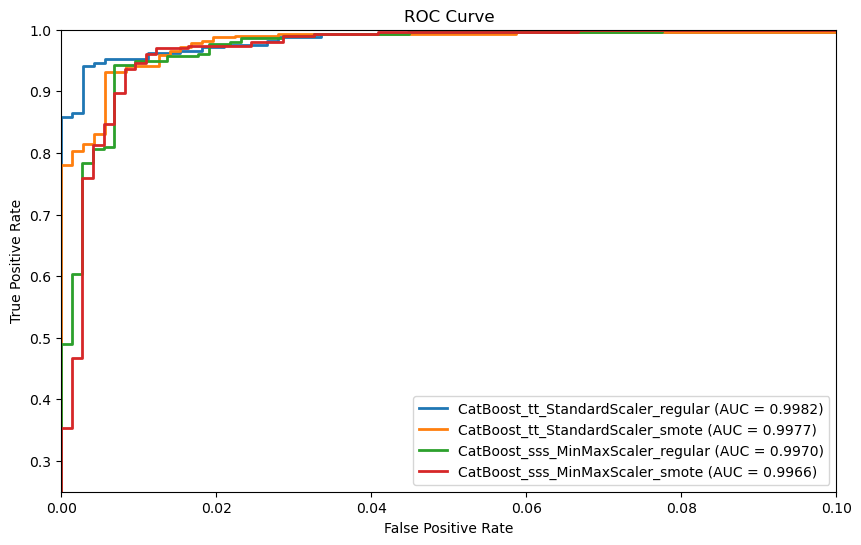

In [124]:
plt.figure(figsize=(10, 6))

for idx, row in combined_df[combined_df.index.isin(ids)].sort_values(by='roc_auc', ascending=False).iterrows():
    fpr, tpr, row_t = row['roc_curve']
    roc_auc = row['roc_auc']
    label=idx
    plot_roc_curve(fpr, tpr, roc_auc,x_max = 0.1, y_min=0.25, label=label)

Smote decreases the performance of the top-performing CatBoost model. Main improvement is having a much Higher True Positive Rate when model has no false positives (left side of graph).

In [ ]:
['CatBoost_sss_MinMaxScaler_smote', 'CatBoost_sss_MinMaxScaler_regular']

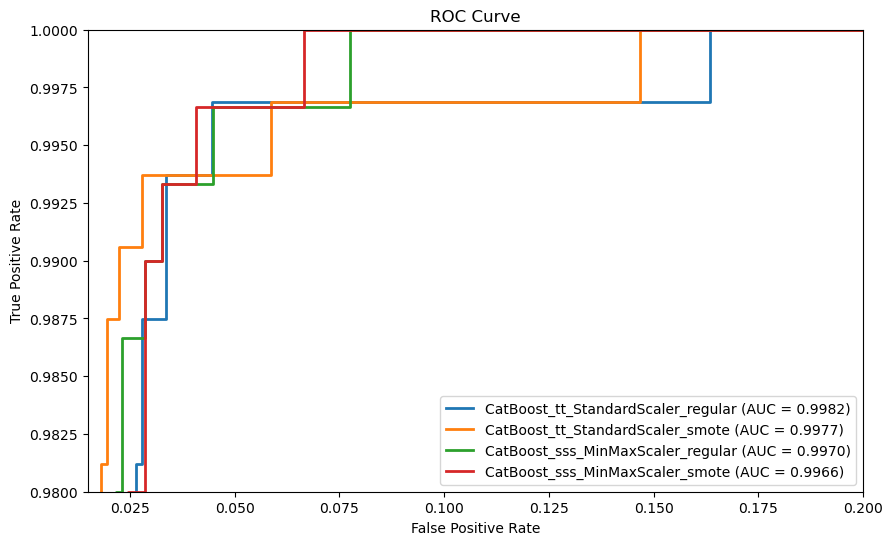

In [144]:
plt.figure(figsize=(10, 6))

for idx, row in combined_df[combined_df.index.isin(ids)].sort_values(by='roc_auc', ascending=False).iterrows():
    fpr, tpr, row_t = row['roc_curve']
    roc_auc = row['roc_auc']
    label=idx
    plot_roc_curve(fpr, tpr, roc_auc,x_min=0.015, y_min=0.98, x_max=0.2, label=label)

The trend has reversed:  
>The higher roc_auc models have to sacrifice a higher False Positive Rate to achieve 100% True Positive Rate.

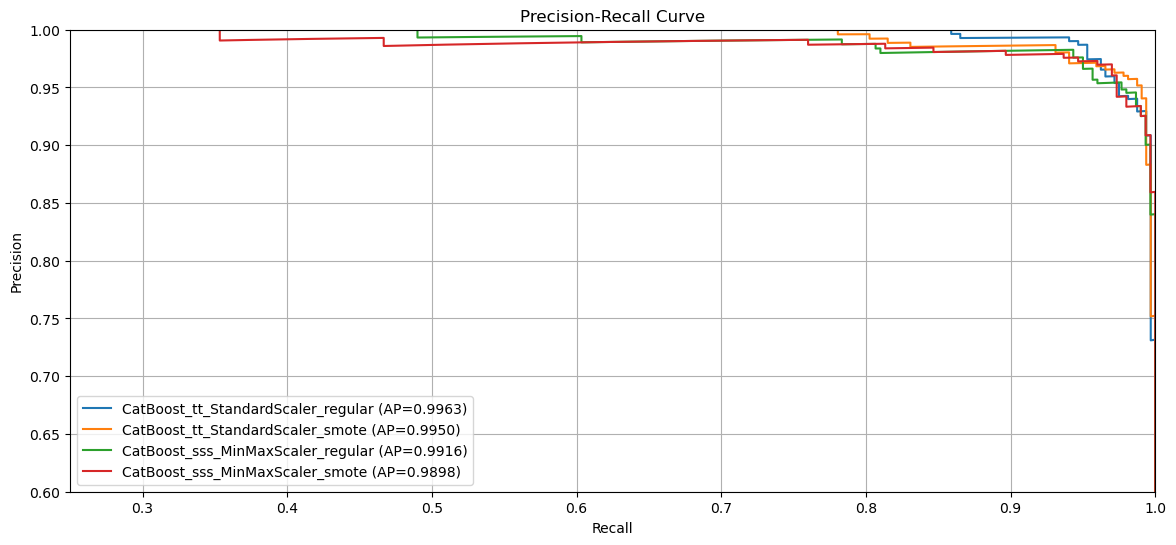

In [155]:
plt.figure(figsize=(14, 6)) 

for idx, row in combined_df[combined_df.index.isin(ids)].sort_values(by='average_precision', ascending=False).iterrows():
    pr = row['precision_recall']
    ap = row['average_precision']
    plot_pr_curve(pr, ap, x_min=0.25, y_min=0.6, label=idx)
    
plt.show()

#### Perfect Precision
>The smote models, orange and red lines, incorrectly classify a regular email as spam, a false positive, a lot earlier than their counterparts. These smote models are not great choices if you want perfect precision.   
A bigger gap is formed between the use of StratifiedShuffleSplit, this decreases recall when you use perfect precision the most. 

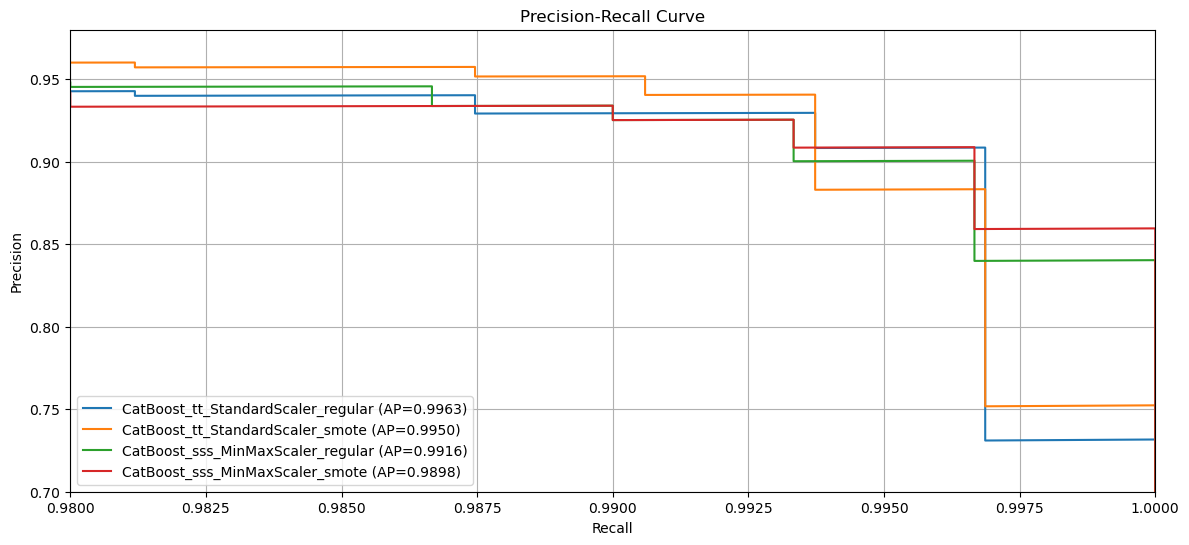

In [166]:
plt.figure(figsize=(14, 6)) 

for idx, row in combined_df[combined_df.index.isin(ids)].sort_values(by='average_precision', ascending=False).iterrows():
    pr = row['precision_recall']
    ap = row['average_precision']
    plot_pr_curve(pr, ap, x_min=0.98, y_min=0.7, y_max=0.98, label=idx)
    
plt.show()

#### Perfect Recall
>Loss in performance with perfect precision = gain in performance with perfect recall. Smote is ideal for better recall, which is due to the imbalanced test set. 

# Model Selections

In [174]:
diff_dc = df_to_diff_dc(combined_df)

In [251]:
perfect_precision = {}
perfect_recall = {}
top_f1s = {}

top_99_rec = {}
top_99_pre = {}

for k,v in diff_dc.items():
    if not v[v['precision'] == 1].empty:
        perfect_precision[k] = v.loc[v['precision'] == 1, 'f1'].values[0]
 
    if not v[v['recall'] == 1].empty:
        perfect_recall[k] = v.loc[v['recall'] == 1, 'f1'].values[0]
   
    top_f1s[k] = v['f1'].max()

    if not v[v['recall'] > 0.99].empty:
        top_99_rec[k] = v[v['recall'] > 0.99]['f1'].max()
        
    if not v[v['precision'] > 0.99].empty:        
        top_99_pre[k] = v[v['precision'] > 0.99]['f1'].max() 

In [253]:
top_f1_df = pd.DataFrame(list(top_f1s.items()), columns=['index', 'max_f1']).set_index('index')
top_f1_df.sort_values(by='max_f1',ascending=False).head(2)

,max_f1
index,
LGBM_skf_MinMaxScaler_smote,0.973422
LGBM_skf_MaxAbsScaler_smote,0.973422


## Top F1 score: LightGBM, StratifiedKFoldSplit, MinMax/MaxAbs  & Smote Sampling

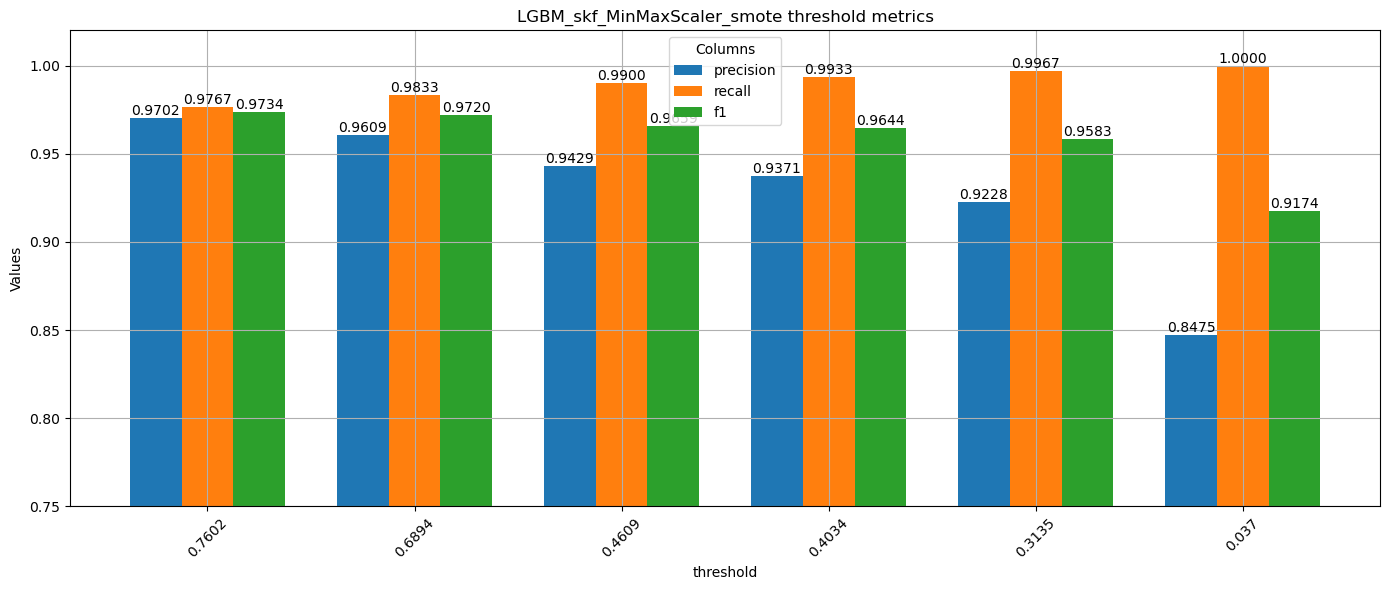

In [197]:
plot_bar_graphs(diff_dc['LGBM_skf_MinMaxScaler_smote'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(6), ['precision','recall','f1'],
    title ='LGBM_skf_MinMaxScaler_smote threshold metrics', horizontal=False, bar_min=0.75,bar_max=1.02,decimal=4, figsize=(14,6))

### f1-score: 0.9734
>Tradeoff: 2.33% of regular emails marked as spam, 2.98% of spam emails allowed in inbox  
  
  Ideal model if expecting equal amounts of spam, and non-spam emails.

## Perfect Recall: ADABoost200, TestTrainSplit, Any Scaling, Regular Sampling

In [247]:
top_recs = pd.DataFrame(list(perfect_recall.items()), columns=['index', 'max_f1']).set_index('index')
top_recs.sort_values(by='max_f1',ascending=False).head(3)

,max_f1
index,
ADABoost200_tt_MinMaxScaler_regular,0.952239
ADABoost200_tt_MaxAbsScaler_regular,0.952239
ADABoost200_tt_StandardScaler_regular,0.952239


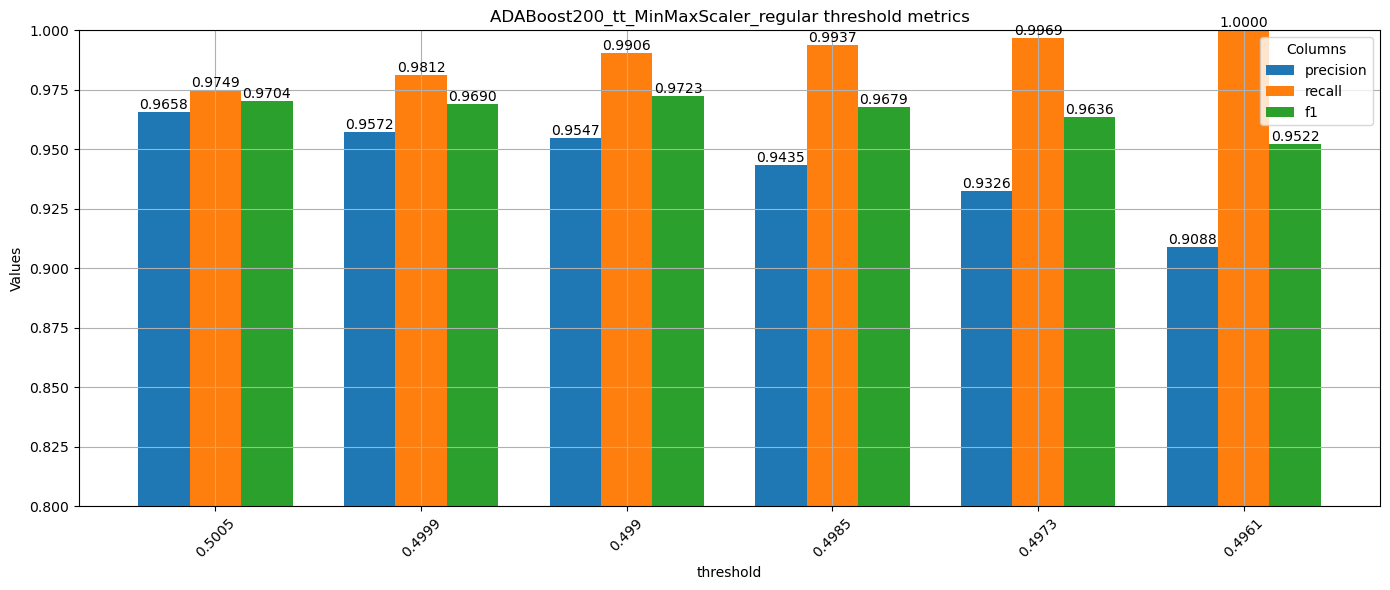

In [214]:
plot_bar_graphs(diff_dc['ADABoost200_tt_MinMaxScaler_regular'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(6), 
['precision','recall','f1'], title ='ADABoost200_tt_MinMaxScaler_regular threshold metrics', horizontal=False, decimal=4, bar_min=0.8, figsize=(14,6))

### f1-score: 0.9522
>Tradeoff: 9.22% of regular emails marked as spam  
  
  Ideal model if expecting mostly spam emails, such as a public facing email account. 

## Over 99% Recall Model: ADABoost (200), Test Train Split, Regular Sampling

In [246]:
top_99_recall = pd.DataFrame(list(top_99_rec.items()), columns=['index', 'max_f1']).set_index('index')
top_99_recall.sort_values(by='max_f1',ascending=False).head(3)

,max_f1
index,
ADABoost200_tt_MaxAbsScaler_regular,0.972308
ADABoost200_tt_MinMaxScaler_regular,0.972308
ADABoost200_tt_StandardScaler_regular,0.972308


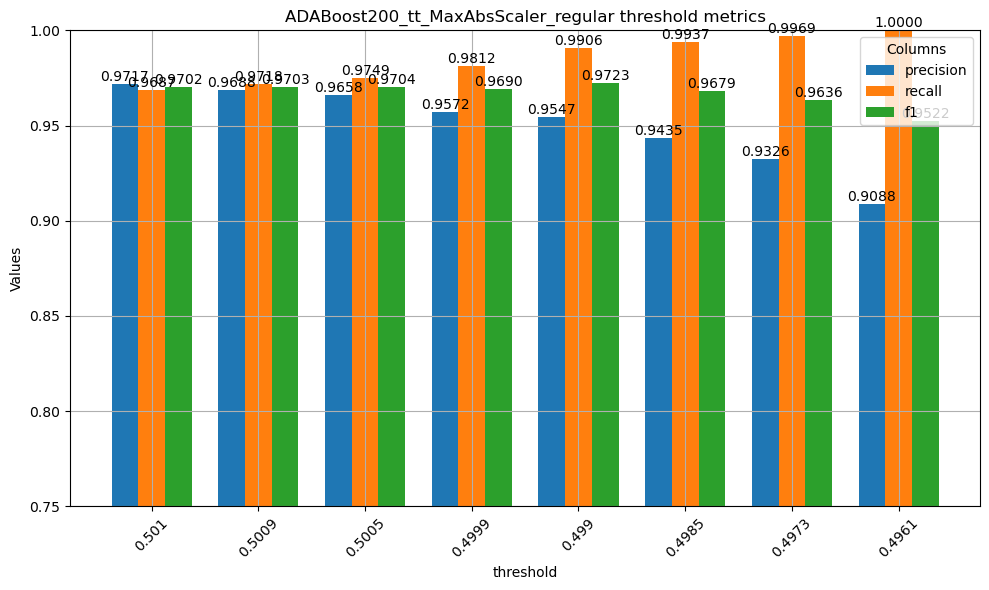

In [237]:
plot_bar_graphs(diff_dc['ADABoost200_tt_MaxAbsScaler_regular'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(8), 
['precision','recall','f1'], title ='ADABoost200_tt_MaxAbsScaler_regular threshold metrics', horizontal=False, decimal=4, bar_min=0.75, figsize=(10,6))

### f1 score: 0.9723
Tradeoff: 0.94%  of spam emails allowed in inbox, 4.53% of regular emails marked as spam

## Perfect Precision: CatBoost, StratifiedKFold, SMOTE Sampling

In [245]:
p_prec = pd.DataFrame(list(perfect_precision.items()), columns=['index', 'max_f1']).set_index('index')
p_prec.sort_values(by='max_f1',ascending=False).head(3)

,max_f1
index,
CatBoost_skf_StandardScaler_smote,0.938053
CatBoost_skf_MaxAbsScaler_smote,0.938053
CatBoost_skf_MinMaxScaler_smote,0.938053


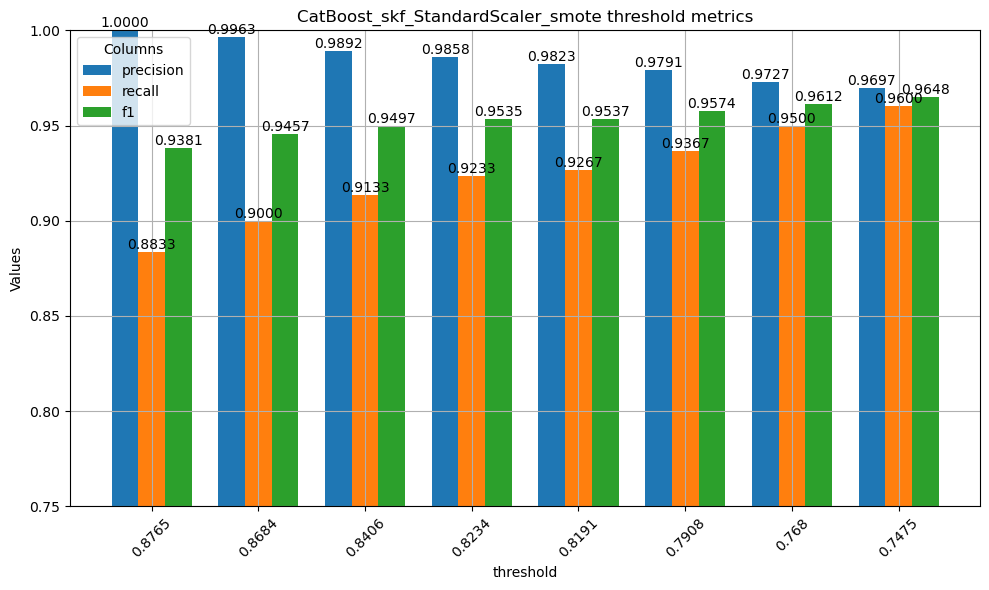

In [218]:
plot_bar_graphs(diff_dc['CatBoost_skf_StandardScaler_smote'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(8), 
['precision','recall','f1'], title ='CatBoost_skf_StandardScaler_smote threshold metrics', horizontal=False, decimal=4, bar_min=0.75, figsize=(10,6))

### f1-score: 0.9381
  >Tradeoff: 88.33% Recall (11.67% of spam allowed in the inbox)  
    
   Ideal model if not expecting spam emails, such as an internal or encrypted email account. 


## High Precision: CatBoost, Test Train Split, Regular Sampling

In [244]:
p99_prec = pd.DataFrame(list(top_99_pre.items()), columns=['index', 'max_f1']).set_index('index')
p99_prec.sort_values(by='max_f1',ascending=False).head(3)

,max_f1
index,
CatBoost_tt_MaxAbsScaler_regular,0.967949
CatBoost_tt_MinMaxScaler_regular,0.967949
CatBoost_tt_StandardScaler_regular,0.967949


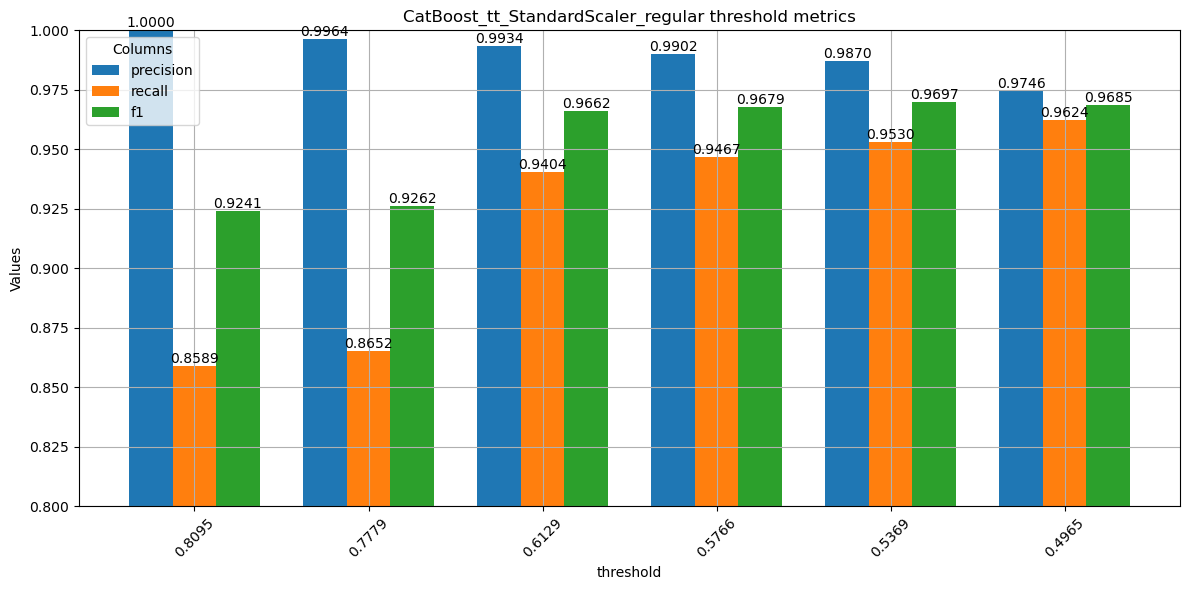

In [243]:
plot_bar_graphs(diff_dc['CatBoost_tt_StandardScaler_regular'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(6), 
['precision','recall','f1'], title ='CatBoost_tt_StandardScaler_regular threshold metrics', horizontal=False, decimal=4, bar_min=0.8, figsize=(12,6))

### f1-score: 0.9662
&nbsp;&nbsp;&nbsp;--0.66% of regular emails to be marked as spam and 5.96% of spam emails in the inbox  
### f1-score: 0.9679
&nbsp;&nbsp;&nbsp;--0.98% of regular emails to be marked as spam and 5.33% of spam emails in the inbox  
### f1-score:  0.9697
&nbsp;&nbsp;&nbsp;--1.3% of regular emails to be marked as spam and 4.7% of spam emails in the inbox  

### Precision/Recall tradeoff: 
>Since this dataset is not balanced: *30% spam*, the tradeoff for gains in precision (when predicting spam, how often does the model do so on a regular email) are hard to come by without sacrificing even more in recall (when predicting spam, how many spam emails did not get predicted)
### Recall increases 7.5%, while precision decreases 0.03%, meaning 7.5% less spam can be allowed in the inbox at a cost of 0.03% more normal emails being marked as spam.   
  

>The f1-score, which will value recall more in an imbalanced dataset such as this one, improves 0.04 
#### The most viable model selection for precisions above 99.0%.  This is a valuable, steep tradeoff that is highly indicative of the best way to tune this model for this data. CatBoost models should use a threshold closer to 61.29% than 77.8%.

In [109]:
import re

def string_array_split(s):
    # Regular expression to match numpy array patterns
    pattern = r'array\(\[(.*?)\]\)'
    
    # Find all matches in the string
    matches = re.findall(pattern, s, re.DOTALL)

    arrays = []
    for match in matches:
        # Clean up the match to remove unwanted characters
        clean_match = match.replace('\n', '').replace(' ', '')
        
        # Convert the cleaned string into a list of numbers
        try:
            # Handle both float and scientific notation numbers
            number_list = [float(num) for num in clean_match.split(',') if num]
            array = np.array(number_list)
            arrays.append(array)
        except ValueError as e:
            print(f"Error converting to array: {e}")

    return arrays


In [51]:
import matplotlib.pyplot as plt

def plot_two_bar_graphs(df1, df2, columns, labels=['df1', 'df2'], title='Model Performance Comparison', x_label=None, y_label='Values',
                        horizontal=False, bar_min=0.90, bar_max=1.00, figsize=(14, 8), legend=True, grid=True, decimal=3,
                        group_spacing=0.1, bar_width=0.3):
    if x_label is None:
        x_label = 'Index'
    
    num_cols = len(columns)
    width = bar_width / 2  # Adjust width for two sets of bars
    x = range(len(df1))  # X positions for bars based on number of indices

    # Adjust spacing between groups
    group_width = width * 2 + group_spacing
    plt.figure(figsize=figsize)
    
    # Collect handles and labels for the legend
    handles = []
    legend_labels = [labels[0], labels[1]]  # Legend only shows dataset names

    if horizontal:
        # Plot bars for both DataFrames
        for i, col in enumerate(columns):
            if col in df1.columns and col in df2.columns:
                offset = group_width * i
                bars1 = plt.barh([p + offset - width / 2 for p in x], df1[col], height=width, color='#1f77b4', label=labels[0])  # Dark Blue
                bars2 = plt.barh([p + offset + width / 2 for p in x], df2[col], height=width, color='#ff7f0e', label=labels[1])  # Dark Orange
                
                # Collect handles
                handles.extend([bars1[0], bars2[0]])
                
                for bar in bars1:
                    label_x = bar.get_width()
                    label_y = bar.get_y() + bar.get_height() / 2
                    plt.text(label_x, label_y, f'{label_x:.{decimal}f}', ha='left', va='center', fontsize=10)

                for bar in bars2:
                    label_x = bar.get_width()
                    label_y = bar.get_y() + bar.get_height() / 2
                    plt.text(label_x, label_y, f'{label_x:.{decimal}f}', ha='left', va='center', fontsize=10)
                
        plt.xlabel(y_label)
        plt.ylabel(x_label)
        plt.yticks(ticks=[p + group_width * (num_cols - 1) / 2 for p in x], labels=df1.index)
        plt.xticks(rotation=45)
        plt.xlim(left=bar_min, right=bar_max)

    else:
        # Plot bars for both DataFrames
        for i, col in enumerate(columns):
            if col in df1.columns and col in df2.columns:
                offset = group_width * i
                bars1 = plt.bar([p + offset - width / 2 for p in x], df1[col], width=width, color='#1f77b4', label=labels[0])  # Dark Blue
                bars2 = plt.bar([p + offset + width / 2 for p in x], df2[col], width=width, color='#ff7f0e', label=labels[1])  # Dark Orange
                
                # Collect handles
                handles.extend([bars1[0], bars2[0]])
                
                for bar in bars1:
                    label_x = bar.get_x() + bar.get_width() / 2
                    label_y = bar.get_height()
                    plt.text(label_x, label_y, f'{bar.get_height():.{decimal}f}', ha='center', va='bottom', fontsize=10)

                for bar in bars2:
                    label_x = bar.get_x() + bar.get_width() / 2
                    label_y = bar.get_height()
                    plt.text(label_x, label_y, f'{bar.get_height():.{decimal}f}', ha='center', va='bottom', fontsize=10)
                
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(ticks=[p + group_width * (num_cols - 1) / 2 for p in x], labels=df1.index, rotation=45)
        plt.ylim(bottom=bar_min, top=bar_max)
    
    plt.title(title)
    if legend:
        plt.legend(handles=handles, labels=legend_labels, title='Datasets')
    plt.grid(grid)
    plt.tight_layout()
    
    plt.show()


In [173]:
def df_to_diff_dc(df):
    pr_curve_dc = {}
    precision_drop_dc = {}

    for idx, row in df.iterrows():
        pr_curve_dc[idx] = create_pr_df(row)[0]
        precision_drop_dc[idx] = create_pr_df(row)[1]

    diffs = create_diff_within(precision_drop_dc)  
    return diffs

In [172]:
def create_diff_within(dc):
    for k,v in dc.items():
        v['precision_diff'] = v['precision'].diff().fillna(0)
        v['recall_diff'] = v['recall'].diff().fillna(0)
        v['f1'] = 2 * (v['precision'] * v['recall']) / (v['precision'] + v['recall'] + 1e-10) 
        v['threshold'] = round(v['threshold'],4)
        v = v.reset_index(drop=True).set_index('threshold')
    return dc

In [171]:
def create_pr_df(row):

    cb_p, cb_r, cb_th = row['precision_recall']
    
    cb_r = cb_r
    cb_p = cb_p
    cb_th = np.append(0, cb_th)

    cb_pr_df = pd.DataFrame({
    'threshold': cb_th,
    'precision': cb_p,
    'recall': cb_r
    })
    
    return cb_pr_df, cb_pr_df[cb_pr_df.index.isin(find_drops(cb_p))].sort_values(by='precision', ascending=False)

In [55]:
def find_drops(y):
  
    diffs = np.diff(y)
    
    return np.where(np.diff(np.sign(diffs)) < 0)[0] + 1


In [56]:
import matplotlib.pyplot as plt

def plot_bar_graphs(df, columns, title='Model Performance Comparison', x_label=None, y_label='Values', 
                     horizontal=False, bar_min=0.90, bar_max=1.00, figsize=(14, 8), legend=True, 
                     grid=True, decimal=3, bar_width=0.75):
    if x_label is None:
        x_label = df.index.name if df.index.name is not None else 'Index'

    num_cols = len(columns)
    width = bar_width / num_cols  # Use the bar_width parameter
    x = range(len(df))
    
    plt.figure(figsize=figsize)
    
    # Collect handles and labels for the legend
    handles = []
    labels = []
    
    if horizontal:
        for i, col in enumerate(columns):
            if col in df.columns:
                offset = width * (i - (num_cols - 1) / 2)
                bars = plt.barh([p + offset for p in x], df[col], height=width, label=col)
                
                # Collect the handle and label
                handles.append(bars[0])
                labels.append(col)
                
                for bar in bars:
                    label_x = bar.get_width()
                    label_y = bar.get_y() + bar.get_height() / 2
                    plt.text(label_x, label_y, f'{label_x:.{decimal}f}', ha='left', va='center', fontsize=10)
                
        plt.xlabel(y_label)
        plt.ylabel(x_label)
        plt.yticks(ticks=[p + width * ((num_cols - 1) / 2) for p in x], labels=df.index)
        plt.xticks(rotation=45)
        plt.xlim(left=bar_min, right=bar_max)

    else:
        for i, col in enumerate(columns):
            if col in df.columns:
                offset = width * (i - (num_cols - 1) / 2)
                bars = plt.bar([p + offset for p in x], df[col], width=width, label=col)
                
                # Collect the handle and label
                handles.append(bars[0])
                labels.append(col)
                
                for bar in bars:
                    label_x = bar.get_x() + bar.get_width() / 2
                    label_y = bar.get_height()
                    plt.text(label_x, label_y, f'{bar.get_height():.{decimal}f}', ha='center', va='bottom', fontsize=10)

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(ticks=[p for p in x], labels=df.index, rotation=45)
        plt.ylim(bottom=bar_min, top=bar_max)
    
    plt.title(title)
    if legend:
        # Reverse the order of handles and labels if the plot is horizontal
        if horizontal:
            handles = handles[::-1]
            labels = labels[::-1]
        plt.legend(handles=handles, labels=labels, title='Columns')
    plt.grid(grid)
    plt.tight_layout()
    
    plt.show()


In [57]:
def plot_roc_curve(fpr, tpr, roc_auc, title='ROC Curve', x_min=0, x_max = 0.125, y_min=0.875, y_max=1.0, label=None):
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')


In [58]:
def plot_pr_curve(precision_recall, average_precision, title='Precision-Recall Curve', x_min=0.75, x_max=1.0, y_min=0.75, y_max=1, label=None):

    precision, recall, _ = precision_recall

    plt.plot(recall, precision, label=f'{label} (AP={average_precision:.4f})')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)

In [59]:
def rp_curve(df, idx):

    p_arr = df.loc[idx,'precision_recall'][0]
    r_arr = df.loc[idx,'precision_recall'][1]
    th_arr = df.loc[idx,'precision_recall'][2]
    avg_r = np.mean(r_arr)
    plot_pr_curve((r_arr,p_arr,th_arr), avg_r, title='Initial Precision Drops', x_min=0.75,x_max=1, y_min=0.75, label=idx)